# Topics

- https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

In [1]:
# from __future__ import print_function, division
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

import random

import _pickle as pickle

from keras_bert import Tokenizer
from keras_bert import load_vocabulary

import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn

from sklearn.manifold import TSNE
import time
import seaborn as sns

    
# %matplotlib inline

Using TensorFlow backend.


In [2]:
%env base netbeans

env: base=netbeans


In [3]:
# https://stackoverflow.com/questions/40115043/no-space-left-on-device-error-while-fitting-sklearn-model
%env JOBLIB_TEMP_FOLDER=/hd/tmp

env: JOBLIB_TEMP_FOLDER=/hd/tmp


In [4]:
MAX_SEQUENCE_LENGTH_T = 20 # 100
MAX_SEQUENCE_LENGTH_D = 20 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [5]:
# Domain to use
DOMAIN = os.environ['base']
PREPROCESSING = 'bert'
TOKEN = 'bert'
# Dataset paths
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = 'data/normalized/{}/{}.csv'.format(DOMAIN, DOMAIN)

In [6]:
df = pd.read_csv(DATASET)

In [7]:
df.head()

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
0,296,normal,CLOSED,debuggertools,1998-06-29 18:54:00 +0000,2002-07-19 15:17:46 +0000,[pslegr]\nIs it now possible to fix that?,[],P4,obsolete,WONTFIX,Debugger does not stop on breakpoints in stati...,3.x
1,302,normal,CLOSED,Code,1998-06-29 19:26:00 +0000,2003-06-30 17:26:30 +0000,Problem appears in:\nStep Over & Step Into act...,[],P4,debugger,WONTFIX,Problem with .class without .java sources.,3.x
2,301,normal,CLOSED,Code,1998-06-29 19:23:00 +0000,2003-06-30 17:26:28 +0000,Priority is changed to P4 (normal).,[],P4,debugger,WONTFIX,Step out action.,3.x
3,365,normal,CLOSED,Code,1998-07-21 22:44:00 +0000,2002-07-19 15:19:34 +0000,"Use gridlayout, set number of columns to one, ...",[],P4,guibuilder,FIXED,After reopen of GridLayout number of cells is bad,3.x
4,367,normal,CLOSED,Code,1998-07-21 23:46:00 +0000,2002-07-19 15:19:34 +0000,Special editor for String to support localizat...,[],P4,guibuilder,FIXED,Property Editor for java.lang.String,3.x


In [8]:
df_textual = df[['bug_id', 'short_desc', 'description']]
df_textual.loc[:, 'text'] = df['short_desc'] + ". " + df['description']
df_textual.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,bug_id,short_desc,description,text
0,296,Debugger does not stop on breakpoints in stati...,[pslegr]\nIs it now possible to fix that?,Debugger does not stop on breakpoints in stati...
1,302,Problem with .class without .java sources.,Problem appears in:\nStep Over & Step Into act...,Problem with .class without .java sources.. Pr...
2,301,Step out action.,Priority is changed to P4 (normal).,Step out action.. Priority is changed to P4 (n...
3,365,After reopen of GridLayout number of cells is bad,"Use gridlayout, set number of columns to one, ...",After reopen of GridLayout number of cells is ...
4,367,Property Editor for java.lang.String,Special editor for String to support localizat...,Property Editor for java.lang.String. Special ...


In [9]:
data = df_textual['text'].values

In [10]:
print("Total of data ", len(data))

Total of data  216715


In [11]:
data[:-2]

array(['Debugger does not stop on breakpoints in static initializer.                                                                                                                                          It seems that this bug cannot be fixed.. [pslegr]\nIs it now possible to fix that?',
       'Problem with .class without .java sources.. Problem appears in:\nStep Over & Step Into actions\n(Step out in future).',
       'Step out action.. Priority is changed to P4 (normal).', ...,
       'org.netbeans.modules.db.sql.loader.SQLCloneableEditor.getToolbarRepresentation: LowPerformance took 47141 ms.. Build: NetBeans IDE 7.4 (Build 201310111528)\nVM: Java HotSpot(TM) Client VM, 24.45-b08, Java(TM) SE Runtime Environment, 1.7.0_45-b18\nOS: Windows XP\n\nUser Comments:\npedropmp: I have no idea what happened\n\nGUEST: <Please provide a description of the problem or the steps to reproduce>\nscanning virus\n\n\n\nMaximum slowness yet reported was 47141 ms, average is 38619',
       'NetBean 

## Bert tokens 

In [12]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')
token_dict = load_vocabulary(vocab_path)
tokenizer = Tokenizer(token_dict)

### Load bugs

In [13]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D,
                   token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [14]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

In [15]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


216715

In [16]:
%%time

experiment.load_bugs(TOKEN)
len(baseline.sentence_dict)


CPU times: user 22.1 s, sys: 2.14 s, total: 24.3 s
Wall time: 24 s


In [17]:
ids = []
data = []
for bug_id in tqdm(baseline.bug_set):
    bug = baseline.bug_set[bug_id]
    ids.append(bug_id)
    title = bug['title']
    desc = bug['description']
    data.append("{}\n{}\n".format(title, desc))

In [18]:
# Normalize minutes
# data = [re.sub(r'[0-9]{1,} (min|minutes|minute|m)', 'x time', str(sent)) for sent in data]
# Normalize dates
# data = [re.sub(r'(\d+/\d+/\d+)', 'date', str(sent)) for sent in data]
# Normalize hours
# data = [re.sub(r'(\d+:\d+:\d+)', 'hour', sent) for sent in data]
data = [re.sub(r'(SEP|CLS)', ' ', sent) for sent in data]
# Remove ponctuation
data = [re.sub(r'\W+', ' ', sent) for sent in data]
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

In [19]:
data[:2]

['de bu gger does not stop on break points in static initial izer it seems that this bug cannot be fixed ps leg r is it now possible to fix that',
 'step out action priority is changed to p 4 normal']

### Tokenization

In [20]:
%%time

def sent_to_words(sentences):
    for sentence in tqdm(sentences):
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])


[['de', 'bu', 'gger', 'does', 'not', 'stop', 'on', 'break', 'points', 'in', 'static', 'initial', 'izer', 'it', 'seems', 'that', 'this', 'bug', 'cannot', 'be', 'fixed', 'ps', 'leg', 'is', 'it', 'now', 'possible', 'to', 'fix', 'that']]
CPU times: user 2min 49s, sys: 1.59 s, total: 2min 51s
Wall time: 2min 50s


### Lemmatization

In [35]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in tqdm(texts):
        doc = nlp(" ".join(sent[:100000])) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [36]:
%%time

# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['gger do stop break point initial izer seem bug be fix leg be fix', 'step action priority be change']
CPU times: user 21min 33s, sys: 1min 15s, total: 22min 49s
Wall time: 22min 49s


## Create the Document-Word matrix

In [37]:
%%time

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10, # minimum reqd occurences of a word 
                             stop_words='english', # remove stop words
                             lowercase=True, # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                             # max_features=50000,  # max number of uniq words    
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

CPU times: user 13.7 s, sys: 39.8 ms, total: 13.7 s
Wall time: 13.7 s


### Selecting best model 

In [38]:
%%time

# Define Search Param
search_params = {'n_components': [10, 20, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0, n_jobs=-1)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)

CPU times: user 39min 37s, sys: 5min 42s, total: 45min 20s
Wall time: 2h 38min 51s


In [39]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'n_components': 30, 'learning_decay': 0.9}
Best Log Likelihood Score:  -62917425.51929622
Model Perplexity:  170.00612570923818


### Dominant topics

In [40]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0.41,0,0,0,0,0,0,0,0.09,0,0,0,0,0.11,0,0,0,0,0,0,0,0,0,0,0,0.21,0,0,0.09,0,0
Doc1,0.01,0.01,0.01,0.01,0.3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.52,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,15
Doc2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.58,0,0,0,0,0,0,0.25,0,0,0.09,0,0,0,0,15
Doc3,0,0,0.22,0,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.22,0,0,4
Doc4,0,0.07,0.07,0,0.12,0,0,0,0,0.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.41,0,0,0,0,25
Doc5,0,0,0,0,0,0,0,0,0.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.12,0,0,0,0,8
Doc6,0.03,0.06,0,0,0.15,0,0.12,0.08,0,0,0.03,0.03,0,0,0,0.43,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0,15
Doc7,0.12,0.1,0,0,0.2,0,0,0,0,0,0.12,0.06,0,0,0,0.28,0,0,0,0,0,0,0.1,0,0,0,0,0,0,0,15
Doc8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.24,0,0,0,0,0,0,0,0,0,0.66,0,0,0,0,25
Doc9,0,0,0.04,0.06,0.28,0,0.29,0,0,0,0,0,0.07,0,0,0,0,0,0,0,0,0.02,0,0,0,0.21,0,0,0,0,6


### Key words topics

In [41]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords

,aaa,aan,aaron,aba,abandon,abbreviate,abbreviation,abc,abe,ability,...,zing,zio,zip,zombie,zon,zone,zoo,zoom,zza,zzle
Topic0,0.033516,0.033596,0.033389,0.033403,0.033380,0.033382,0.033385,0.033390,0.033386,0.033430,...,0.033456,0.033378,0.033437,0.073612,0.033385,0.033380,0.033382,0.033372,0.033379,0.034870
Topic1,0.048804,0.033392,0.033384,15.450398,0.036947,0.033392,0.033380,0.033384,0.050740,0.033385,...,5.483367,0.033379,0.037964,0.033383,0.033463,0.033379,0.033381,0.033382,0.033686,0.033406
Topic2,1091.561073,3.572270,0.033376,0.033383,0.033376,0.033381,0.033415,0.033417,0.036349,7.827178,...,0.033397,0.033913,0.057438,7.367966,0.033375,0.033375,0.033389,0.033381,0.033437,0.033839
Topic3,0.035854,0.033383,0.033380,0.033388,0.033393,0.033370,0.033406,0.034343,0.033380,0.042963,...,99.064886,71.565477,0.033408,0.033376,0.033373,0.033438,0.034248,0.040125,0.033501,0.033812
Topic4,0.033384,0.033383,0.033382,0.033386,0.033397,20.043762,0.033404,0.033383,137.645625,0.033474,...,0.033411,0.034036,0.033896,0.033380,0.036327,35.765637,58.575715,0.033391,0.033383,0.033803
Topic5,0.033378,0.033383,0.033381,22.981894,0.033566,0.033383,0.033389,0.033375,536.221532,0.061210,...,213.413958,0.033380,469.972308,0.033510,1.067632,0.033385,0.033377,0.033384,0.033799,0.033377
Topic6,0.036023,0.033386,0.033374,0.033374,0.033382,0.033382,0.033382,0.033383,0.033384,0.033405,...,0.033409,0.033401,0.033403,0.033382,0.033385,0.033381,0.033379,0.033372,0.033379,0.033378
Topic7,0.033653,20.931078,0.033383,0.033386,6.214858,0.033378,0.033374,803.182490,0.033427,13.920430,...,0.033402,0.033378,0.033444,2.308254,0.033486,0.033396,3.928346,0.035504,0.033381,0.033377
Topic8,0.033389,0.033377,0.033380,0.033393,0.033377,0.034129,535.100286,0.033385,0.033405,0.033555,...,0.033376,0.033720,0.033491,0.033748,0.033380,0.033996,0.033375,0.033380,0.033544,0.033384
Topic9,0.033381,0.033372,0.033381,26.438031,0.036115,0.033374,0.033420,0.061968,0.033443,12.207713,...,0.033484,9.155033,0.033386,0.034110,82.338873,0.033436,0.033372,0.033401,0.033413,0.033385


### Get the top 15 words by topic

In [42]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=None, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,point,line,gger,ere,break,var,start,application,variable,step,run,session,enterprise,create,set
Topic 1,java,net,org,sor,request,run,ans,ger,base,task,mana,module,ception,del,stor
Topic 2,test,del,field,string,ete,case,create,feature,ivo,eti,element,hema,unit,map,fail
Topic 3,web,window,page,frame,html,help,screen,link,browser,hel,ice,content,application,ien,ize
Topic 4,button,index,list,press,search,result,change,work,tab,drop,use,value,enter,text,function
Topic 5,net,module,ans,java,jar,program,web,core,api,class,xml,gger,sun,form,editor
Topic 6,java,event,eve,tch,dis,rea,dispatch,container,component,net,form,pump,act,ion,window
Topic 7,server,platform,plug,script,application,wizard,connection,database,col,sql,beta,connect,target,mobility,symbol
Topic 8,component,cus,izer,group,tom,custom,pone,mana,palette,bean,ger,ane,form,pan,category
Topic 9,editor,form,model,text,hint,option,itor,ator,ent,kit,hema,ind,xml,mark,color


## Save topics for each bug

In [43]:
X = np.array([row[:-1] for row in df_document_topic.values])
y = np.array([row[-1] for row in df_document_topic.values])
classes = np.unique(y)
X.shape, y.shape, classes.shape, np.asarray(ids).shape

((216715, 30), (216715,), (30,), (216715,))

In [44]:
for i in tqdm(range(len(ids))):
    filename = 'bugs/{}.pkl'.format(ids[i])
    try:
        with open(os.path.join(DIR, filename), 'rb') as f:
            bug = pickle.load(f)
            # Update bugs with topics
            bug['topics'] = X[i]
            bug['topic'] = int(y[i])
            bug['topic_index'] = int(y[i]) - 1
    except:
        bug = {}
    if('topic' not in bug):
        print("Bug of index {} was not saved".format(i))
        continue
    bug_dir = os.path.join(DIR, 'bugs')
    with open(os.path.join(bug_dir, str(ids[i]) + '.pkl'), 'wb') as f:
        pickle.dump(bug, f)

### Visualize topics embed space

In [45]:
def create_tsne(X):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_results

In [46]:
def plot_clusters(y, tsne_results, classes):
    df_subset = {}
    df_subset['y'] = y
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", len(classes)),
        data=df_subset,
        legend="full",
        alpha=0.8
    )

In [47]:
X_tsne = X[:1000]
y_tsne = y[:1000]
classes = np.unique(y_tsne)

In [48]:
tsne_results = create_tsne(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.181254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.663414
[t-SNE] Error after 300 iterations: 1.004934
t-SNE done! Time elapsed: 4.565024137496948 seconds


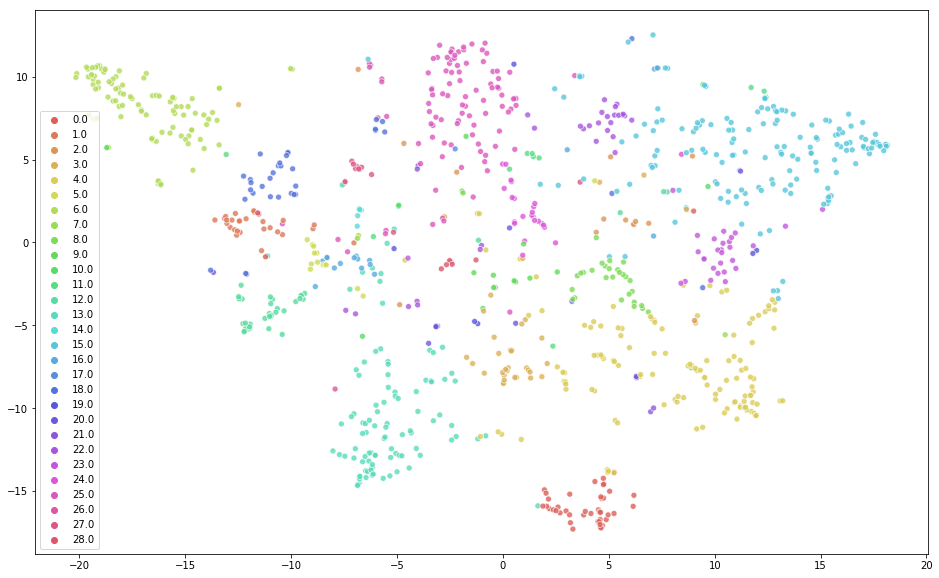

In [49]:
plot_clusters(y_tsne, tsne_results, classes)